# Multiple Subject Processing

# Original Hypothesis
- chronical analysis: maybe high-high decrease steadily while the others stay the same?

# TBD:
- note down the IC components to be rejected to save resource

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mne
from mne_bids import (BIDSPath,read_raw_bids)
import sys
sys.path.insert(0,'.')
import os
import gc
from tqdm.notebook import tqdm
from pathlib import Path

import ccs_eeg_utils
import config
from tools import get_valid_input
from visualization import plot_erp, plot_topo_serires, plot_binning_results
from s00_add_reference import add_reference_channel
from s01_downsample_filter import down_sampling, band_filter, notch_filter
from s02_drop_bad_channels import drop_bad_channels, reref
from s03_07_trial_rejection import trial_rejection_cust, trial_rejection_mne
from s04_ICA import get_ica, get_iclabel, iccomponent_removal_author, iccomponent_removal_new
from s05_interpolation import interpolation
from s06_early_trial_removal import exclude_early_trials
from s07_epoching import epoching, epoching_cust
from s09_make_erps import get_evoked, get_evoked_difference, compute_grand_average
from s10_rewp_calculation import rewp_calculation

from stats.rewp_scores import compute_rewp_scores, save_rewp_scores, load_rewp_scores, run_rewp_parametric_from_scores, save_parametric_results
from stats.rewp_robust import run_rewp_robustness, save_robustness_results
from stats.logging_utils import setup_rewp_logger

from binning import binning

In [3]:
SUBJECTS = list(config.SUBJECT_INFO.keys())
LEARNERS = [subject_id for subject_id in config.SUBJECT_INFO.keys() if config.SUBJECT_INFO[subject_id]['learner']]

USER = get_valid_input(
    'Select the user (options: qian/zheng): ',
    list(config.BIDS_ROOT.keys())
)

Input accepted:qian


In [4]:
### Dictionary for trial rejeciton for ica
ica_trial_dict = config.CONDITIONS_DICT['onset_locked']
### Dictionary for epoching conditions
epoch_dict = config.CONDITIONS_DICT['feedback_locked']

### Subject info list
subject_info = config.SUBJECT_INFO

# bin number (CHANGE)
n_bins = config.N_BINS

In [5]:
root = config.BIDS_ROOT[USER]
# montage setup
montage_site2_path = os.path.join(root, 'code', config.LOCS_FILENAME['site2']) 
montage_site2 = mne.channels.read_custom_montage(montage_site2_path)
montage_common_path = os.path.join(root, 'code', config.LOCS_FILENAME['common'])
montage_common = mne.channels.read_custom_montage(montage_common_path)

In [6]:
mne.set_log_level('WARNING') # to avoid too many info messages

# Processing function

In [18]:
### Get the group evokeds and binned group evokeds
def get_group_evokeds(ACTIVE_PIPELINE, learners_only=False):
    group_evokeds = {}
    binned_group_evokeds = {}

    if learners_only:
        subjects = LEARNERS
    else:
        subjects = SUBJECTS

    for subject_id in tqdm(subjects, desc='Processing subjects', leave=True):
        # ------ LOAD DATA ------
        cfg = config.PIPELINES[ACTIVE_PIPELINE]
        bids_path = BIDSPath(subject=subject_id, task='casinos',
                            datatype='eeg', suffix='eeg',
                            root=root)
        # read the file
        raw = read_raw_bids(bids_path)
        raw.load_data() 
        # fix the annotations readin
        ccs_eeg_utils.read_annotations_core(bids_path,raw)

        # ------- PREPROCESSING PIPELINE -------
        # Add reference channel Fz
        raw = add_reference_channel(raw, 'Fz') 

        # Set custom montage
        raw.set_montage(montage_site2, match_case=False)

        # Downsample to 250 Hz
        eeg_down = down_sampling(raw, verbose=False)

        if ACTIVE_PIPELINE != 'original':
            # Make a copy for ica analysis
            eeg_ica = band_filter(eeg_down.copy(), f_low=1, f_high=100)

        # Bandpass filter 0.1-30 Hz
        eeg_band = band_filter(eeg_down)

        # Notch filter at 50 Hz and harmonics
        eeg_band_notch = notch_filter(eeg_band)

        # Drop bad channels and reference channel
        eeg_band_notch = drop_bad_channels(subject_info[subject_id]['bad_channels'], eeg_band_notch)   #input: bad channels from previous run, eeg
        eeg_band_notch = reref(eeg_band_notch)
        if ACTIVE_PIPELINE != 'original':
            eeg_ica = drop_bad_channels(subject_info[subject_id]['bad_channels'], eeg_ica)
            eeg_ica = reref(eeg_ica)

        # Trial rejection using customized function
        rejection_params = cfg['rejection_params']['ica']
        if ACTIVE_PIPELINE == 'original':
            trials, rejection_info = trial_rejection_cust(eeg_band_notch, ica_trial_dict, **rejection_params)
        else:   # proposed with MNE built-in trial rejection
            trials = trial_rejection_mne(eeg_ica, ica_trial_dict, **rejection_params)
        
        # ICA and ICLabel
        ica = get_ica(trials, cfg['ica_method'])
        eeg_band_notch = iccomponent_removal_author(eeg_band_notch, trials, ica)

        # Interpolation of bad channels
        eeg_band_notch = interpolation(eeg_band_notch, verbose=False)

        # exclude early trials
        eeg_final = exclude_early_trials(eeg_band_notch, cfg['early_trial_deletion'], verbose=False)

        # Epoching
        rejection_params = cfg['rejection_params']['erp']
        if ACTIVE_PIPELINE == 'original':
            epochs_all, rejection_info = epoching_cust(epoch_dict, eeg_final, **rejection_params)
        else:
            epochs_all = epoching(epoch_dict, eeg_final, **rejection_params)
        
        # Get evoked responses
        all_evokeds = get_evoked(epoch_dict, epochs_all, proportiontocut=cfg['evoked_proportiontocut'])

        group_evokeds[subject_id] = all_evokeds

        del raw
        gc.collect()

        # binned epochs
        binned_epochs = binning(epochs_all, config.CONDITIONS_DICT['feedback_locked'], bin_num=n_bins)
        binned_evokeds = []
        for i in range(n_bins):
            # get the binned epochs across conditions
            binned_evokeds.append(get_evoked(epoch_dict, binned_epochs[i+1], proportiontocut=cfg['evoked_proportiontocut']))
        binned_group_evokeds[subject_id] = binned_evokeds


    return group_evokeds, binned_group_evokeds

# Authors' pipeline

## All subjects

In [ ]:
ACTIVE_PIPELINE = 'original'
group_evokeds_ori, binned_group_evokeds_ori = get_group_evokeds(ACTIVE_PIPELINE)

In [8]:
grand_averages_ori = compute_grand_average(epoch_dict, group_evokeds_ori)

In [ ]:
# calculate the grand averages for each bin
binned_grand_averages_ori = []
for i in range(n_bins):
    binned_grand_averages_ori.append(compute_grand_average(epoch_dict, {subj: binned_group_evokeds_ori[subj][i] for subj in SUBJECTS}))

# calculate RewP results for each bin
results_allbin_ori = []
for i, evokeds in enumerate(binned_grand_averages_ori):
    results_allbin_ori.append(rewp_calculation(evokeds, epoch_dict, verbose=False))

### Plotting

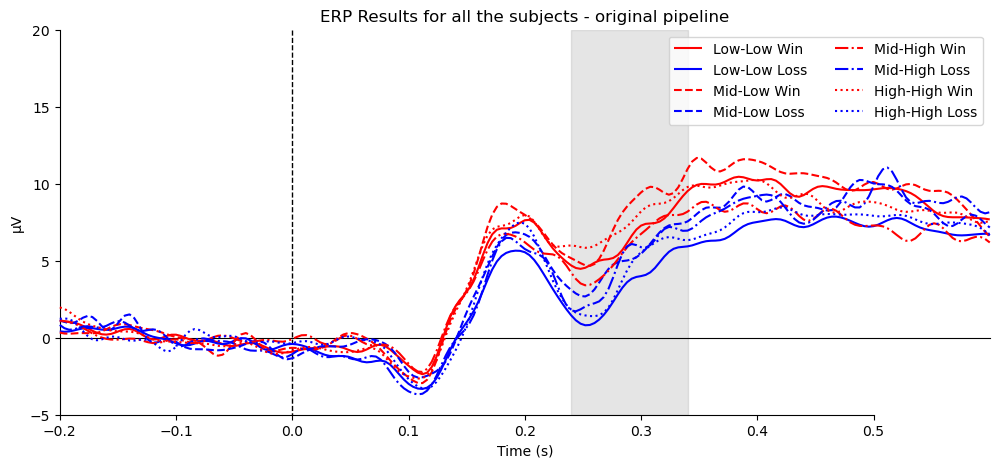

In [9]:
plot_erp(grand_averages_ori, ylim=[-5, 20], diff=False, title=f"ERP Results for all the subjects - {ACTIVE_PIPELINE} pipeline");

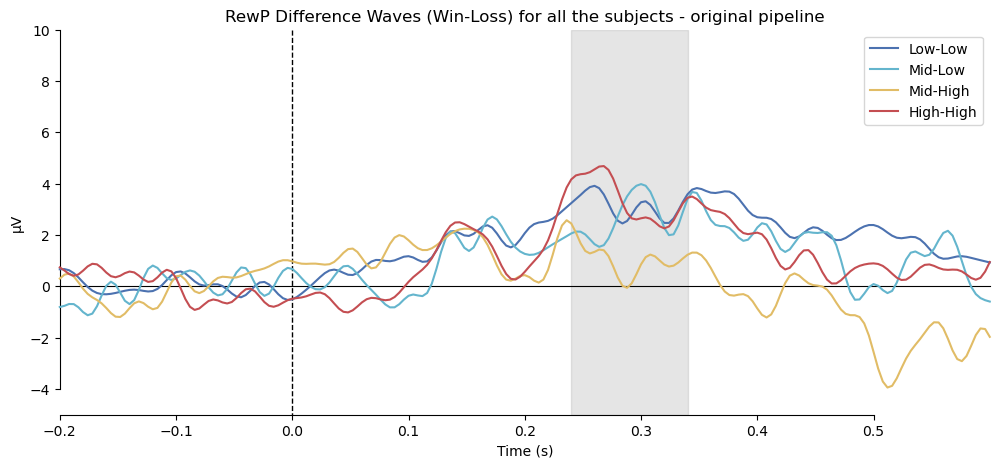

In [10]:
diff_evokeds_ori = get_evoked_difference(grand_averages_ori)
plot_erp(diff_evokeds_ori, diff=True, title=f"RewP Difference Waves (Win-Loss) for all the subjects - {ACTIVE_PIPELINE} pipeline");

Plotting Topomap for: Low-Low


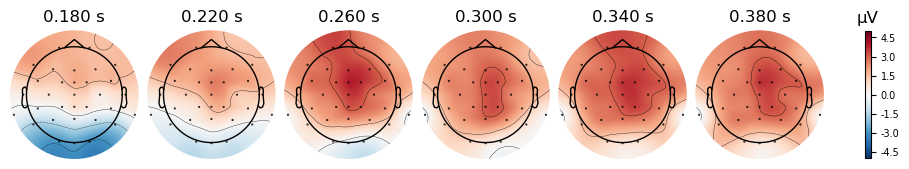

Plotting Topomap for: Mid-Low


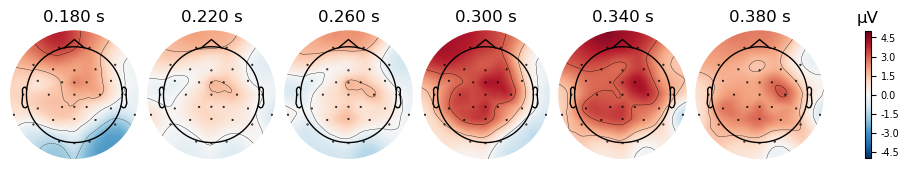

Plotting Topomap for: Mid-High


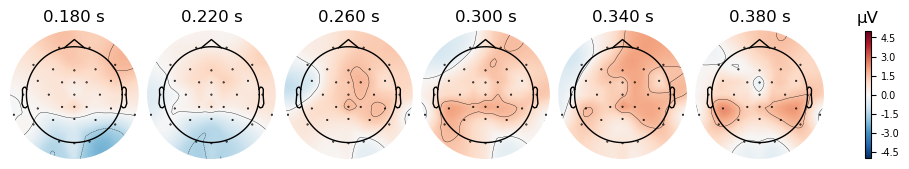

Plotting Topomap for: High-High


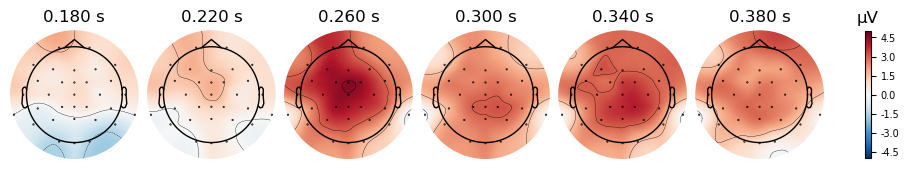

In [11]:
plot_topo_serires(diff_evokeds_ori)

In [ ]:
plot_binning_results(results_allbin_ori, title=f'RewP Mean Amplitude Across Chronological Bins - {ACTIVE_PIPELINE} pipeline')

## Learners only

In [14]:
ACTIVE_PIPELINE = 'original'
group_evokeds_ori_learner, binned_group_evokeds_ori_learner = get_group_evokeds(ACTIVE_PIPELINE, learners_only=True)

Processing subjects:   0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_38075/2199141125.py:18: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 27
date: 18-Mar-2022 13:55:40
handedness: R
order: 50-50 mixed 80-20
stimuli: a lemon an orange
  raw = read_raw_bids(bids_path)


Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 410 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 410 events and 751 original time points ...
Fitting ICA took 49.4s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_ind

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 362 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 362 events and 751 original time points ...
Fitting ICA took 38.4s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_ind

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 418 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 418 events and 751 original time points ...
Fitting ICA took 45.3s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_ind

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 429 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 429 events and 751 original time points ...
Fitting ICA took 46.2s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_ind

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 330 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 330 events and 751 original time points ...
Fitting ICA took 40.7s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_ind

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_38075/2199141125.py:18: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 36
date: 13-Apr-2022 12:21:42
handedness: R
order: mixed 80-20 50-50
stimuli: a cherry a lemon
  raw = read_raw_bids(bids_path)


Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 422 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 422 events and 751 original time points ...
Fitting ICA took 47.7s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_ind

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 425 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 425 events and 751 original time points ...
Fitting ICA took 46.3s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_ind

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 431 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 431 events and 751 original time points ...
Fitting ICA took 47.9s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_ind

In [13]:
grand_averages_ori_learner = compute_grand_average(epoch_dict, group_evokeds_ori_learner)

In [15]:
# calculate the grand averages for each bin
binned_grand_averages_ori_learner = []
for i in range(n_bins):
    binned_grand_averages_ori_learner.append(compute_grand_average(epoch_dict, {subj: binned_group_evokeds_ori_learner[subj][i] for subj in LEARNERS}))

# calculate RewP results for each bin
results_allbin_ori_learner = []
for i, evokeds in enumerate(binned_grand_averages_ori_learner):
    results_allbin_ori_learner.append(rewp_calculation(evokeds, epoch_dict, verbose=False))

### plotting

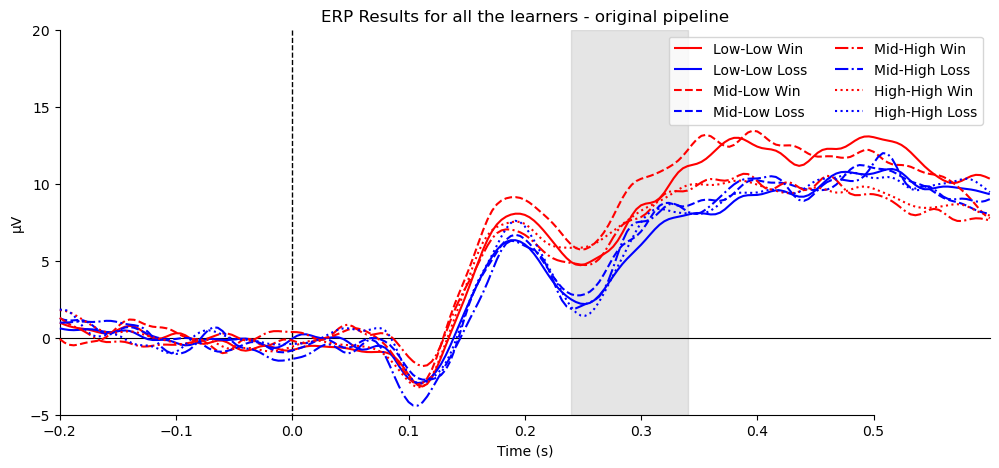

In [14]:
plot_erp(grand_averages_ori_learner, ylim=[-5, 20], diff=False, title=f"ERP Results for all the learners - {ACTIVE_PIPELINE} pipeline");

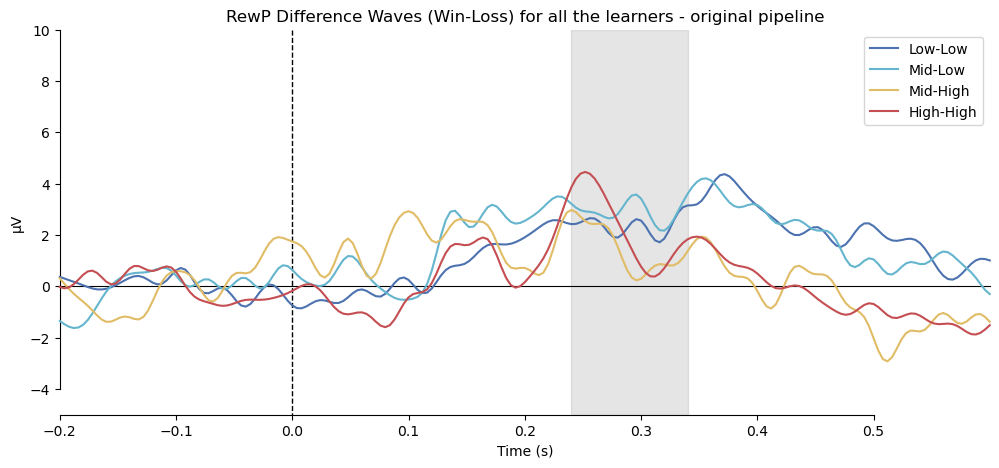

In [15]:
diff_evokeds_ori_learner = get_evoked_difference(grand_averages_ori_learner)
plot_erp(diff_evokeds_ori_learner, diff=True, title=f"RewP Difference Waves (Win-Loss) for all the learners - {ACTIVE_PIPELINE} pipeline");

Plotting Topomap for: Low-Low


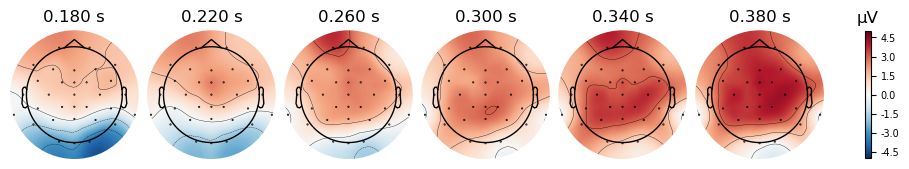

Plotting Topomap for: Mid-Low


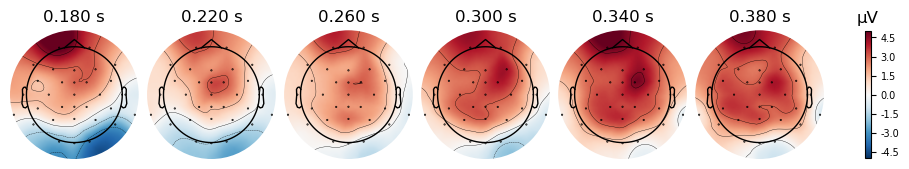

Plotting Topomap for: Mid-High


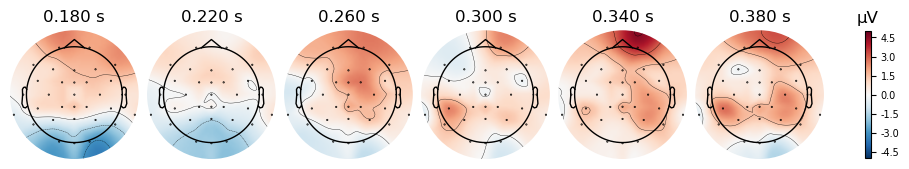

Plotting Topomap for: High-High


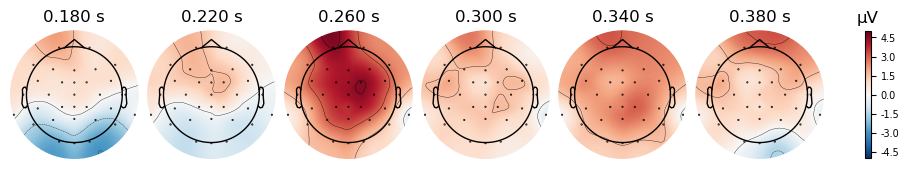

In [16]:
plot_topo_serires(diff_evokeds_ori_learner)

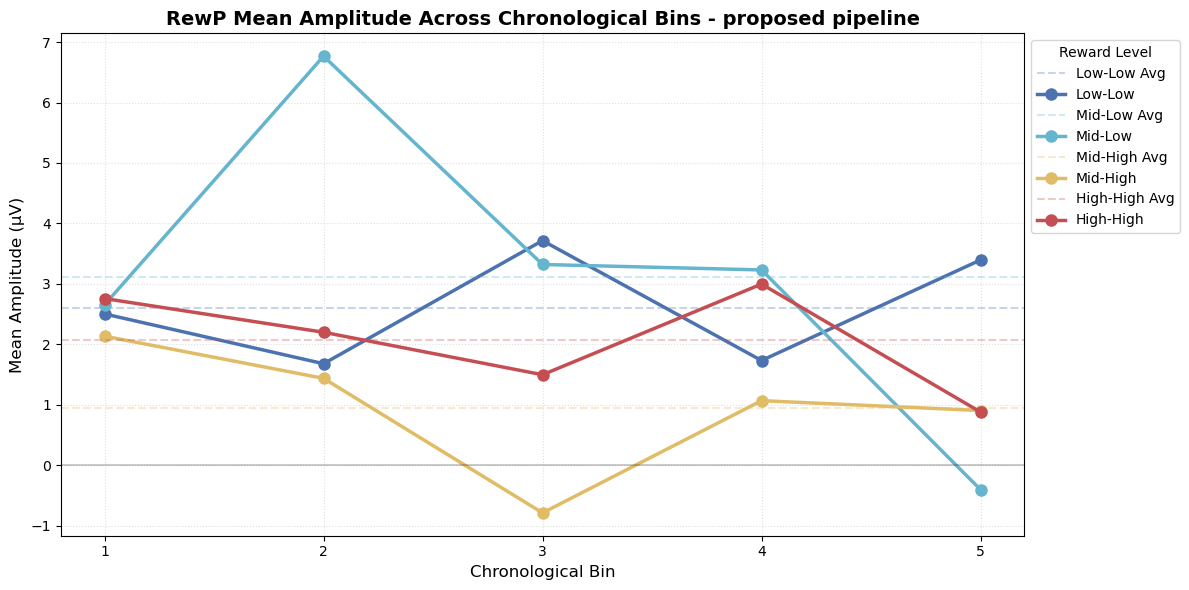

In [23]:
plot_binning_results(results_allbin_ori_learner, title=f'RewP Mean Amplitude Across Chronological Bins - {ACTIVE_PIPELINE} pipeline')

# (TBC) ours pipeline

## All subjects

In [ ]:
ACTIVE_PIPELINE = 'propsed'
group_evokeds_prop, binned_group_evokeds_prop = get_group_evokeds(ACTIVE_PIPELINE)

In [18]:
grand_averages_prop = compute_grand_average(epoch_dict, group_evokeds_prop)

In [ ]:
# calculate the grand averages for each bin
binned_grand_averages_prop = []
for i in range(n_bins):
    binned_grand_averages_prop.append(compute_grand_average(epoch_dict, {subj: binned_group_evokeds_prop[subj][i] for subj in SUBJECTS}))

# calculate RewP results for each bin
results_allbin_prop = []
for i, evokeds in enumerate(binned_grand_averages_prop):
    results_allbin_prop.append(rewp_calculation(evokeds, epoch_dict, verbose=False))

### Plotting

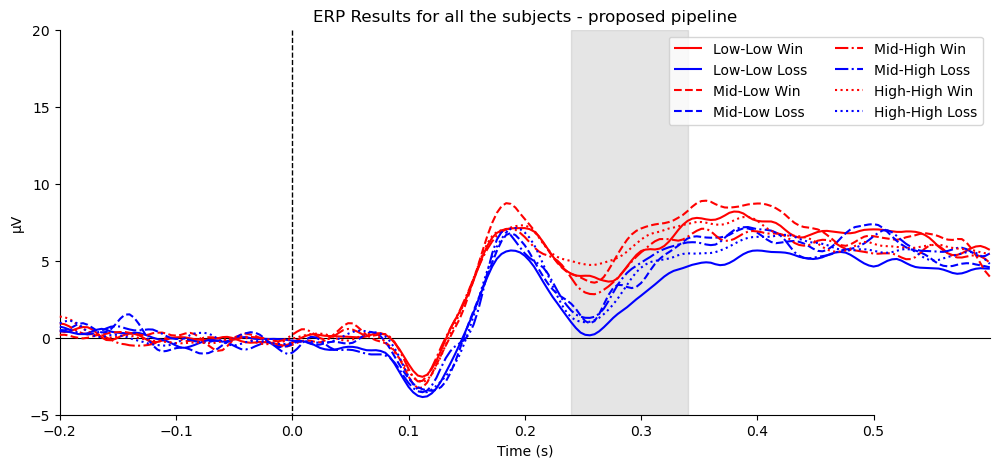

In [19]:
plot_erp(grand_averages_prop, ylim=[-5, 20], diff=False, title=f"ERP Results for all the subjects - {ACTIVE_PIPELINE} pipeline");

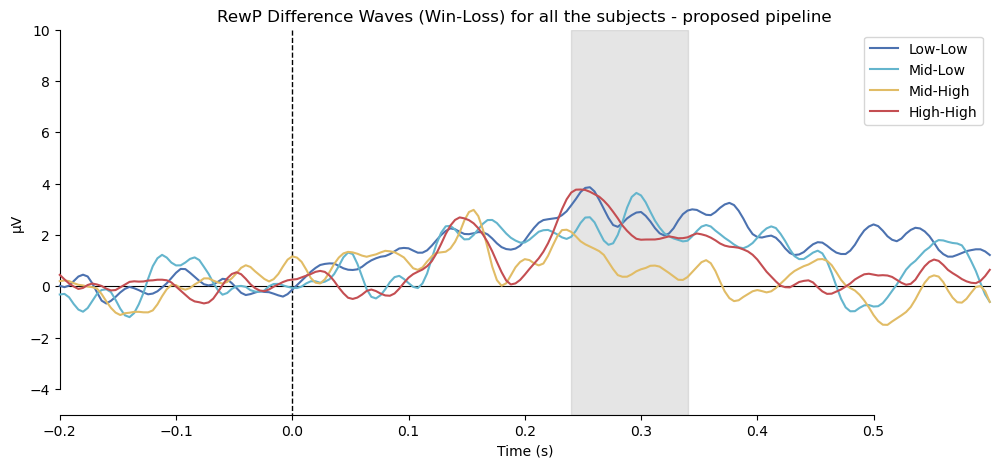

In [20]:
diff_evokeds_prop = get_evoked_difference(grand_averages_prop)
plot_erp(diff_evokeds_prop, diff=True, title=f"RewP Difference Waves (Win-Loss) for all the subjects - {ACTIVE_PIPELINE} pipeline");

Plotting Topomap for: Low-Low


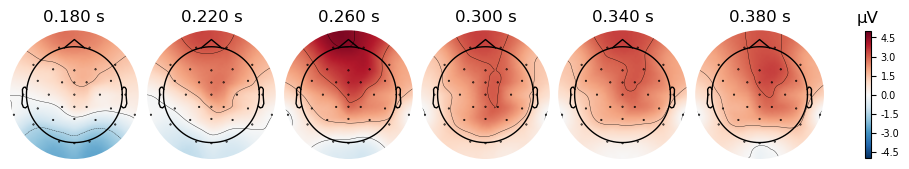

Plotting Topomap for: Mid-Low


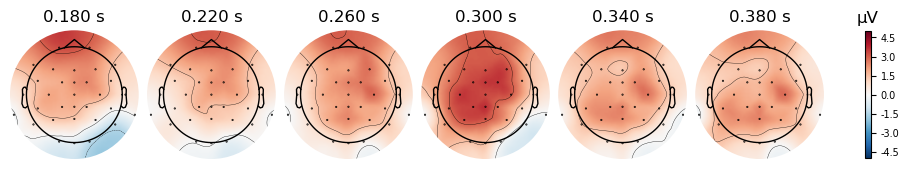

Plotting Topomap for: Mid-High


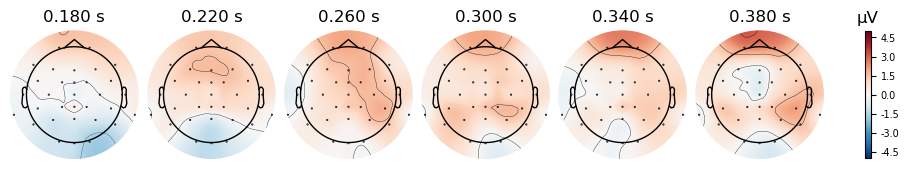

Plotting Topomap for: High-High


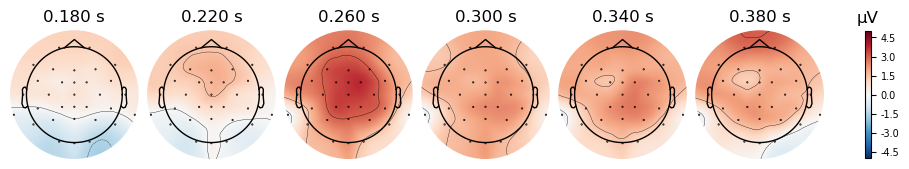

In [21]:
plot_topo_serires(diff_evokeds_prop)

In [ ]:
plot_binning_results(results_allbin_prop, title=f'RewP Mean Amplitude Across Chronological Bins - {ACTIVE_PIPELINE} pipeline')

## Learners only

In [19]:
ACTIVE_PIPELINE = 'proposed'
group_evokeds_prop_learner, binned_group_evokeds_prop_learner = get_group_evokeds(ACTIVE_PIPELINE, learners_only=True)

Processing subjects:   0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_38075/4137529789.py:18: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 27
date: 18-Mar-2022 13:55:40
handedness: R
order: 50-50 mixed 80-20
stimuli: a lemon an orange
  raw = read_raw_bids(bids_path)


Average Reference: Keeping both.
Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 31 components
Fitting ICA took 20.4s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/

Average Reference: Keeping both.
Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 31 components
Fitting ICA took 26.2s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/

Average Reference: Keeping both.
Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 31 components
Fitting ICA took 14.6s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/

Average Reference: Keeping both.
Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 31 components
Fitting ICA took 25.2s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/

Average Reference: Keeping both.
Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 31 components
Fitting ICA took 85.3s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_38075/4137529789.py:18: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 36
date: 13-Apr-2022 12:21:42
handedness: R
order: mixed 80-20 50-50
stimuli: a cherry a lemon
  raw = read_raw_bids(bids_path)


Average Reference: Keeping both.
Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 31 components
Fitting ICA took 19.7s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/

Average Reference: Keeping both.
Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 31 components
Fitting ICA took 21.0s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/

Average Reference: Keeping both.
Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 31 components
Fitting ICA took 23.5s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/binning.py:62: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  binned_epochs_combined[bin_index] = mne.concatenate_epochs(binned_epochs_combined[bin_index])
/Users/qianyueli/Documents/UniStuttgart/

In [20]:
grand_averages_prop_learner = compute_grand_average(epoch_dict, group_evokeds_prop_learner)

In [25]:
# calculate the grand averages for each bin
binned_grand_averages_prop_learner = []
for i in range(n_bins):
    binned_grand_averages_prop_learner.append(compute_grand_average(epoch_dict, {subj: binned_group_evokeds_prop_learner[subj][i] for subj in LEARNERS}))

# calculate RewP results for each bin
results_allbin_prop_learner = []
for i, evokeds in enumerate(binned_grand_averages_prop_learner):
    results_allbin_prop_learner.append(rewp_calculation(evokeds, epoch_dict, verbose=False))

### Plotting

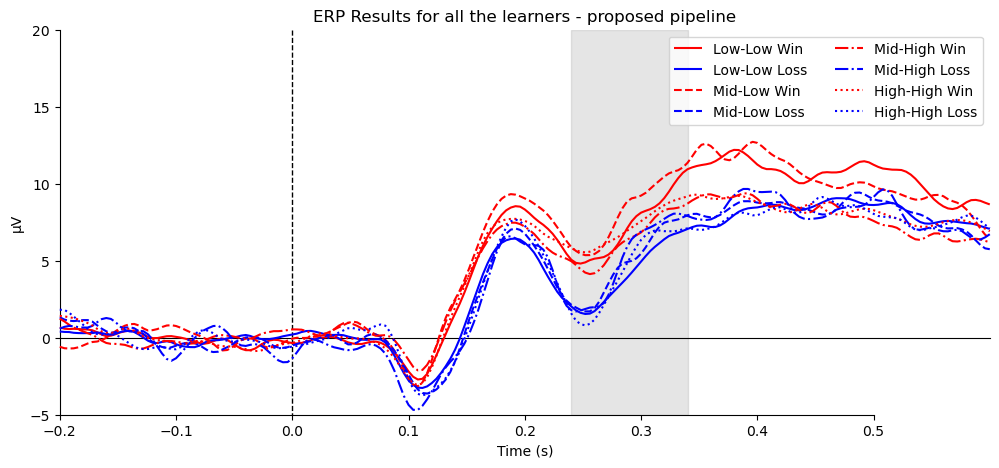

In [26]:
plot_erp(grand_averages_prop_learner, ylim=[-5, 20], diff=False, title=f"ERP Results for all the learners - {ACTIVE_PIPELINE} pipeline");

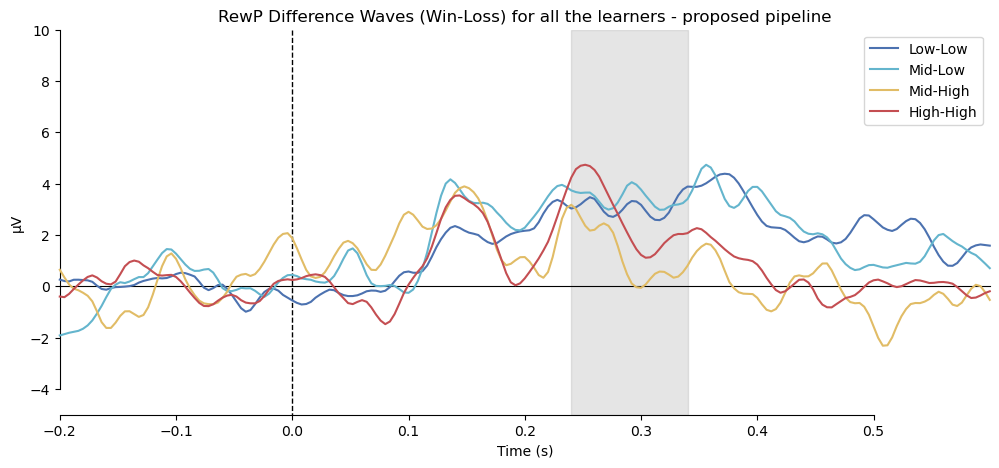

In [22]:
diff_evokeds_prop_learner = get_evoked_difference(grand_averages_prop_learner)
plot_erp(diff_evokeds_prop_learner, diff=True, title=f"RewP Difference Waves (Win-Loss) for all the learners - {ACTIVE_PIPELINE} pipeline");

Plotting Topomap for: Low-Low


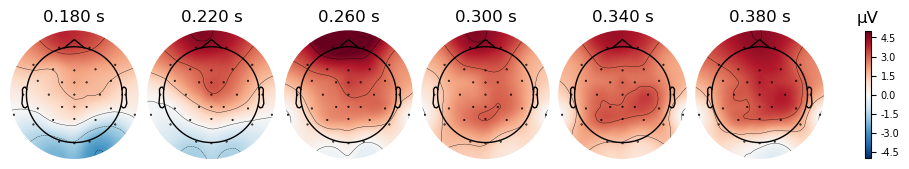

Plotting Topomap for: Mid-Low


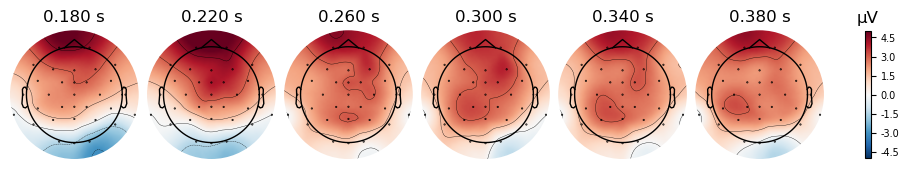

Plotting Topomap for: Mid-High


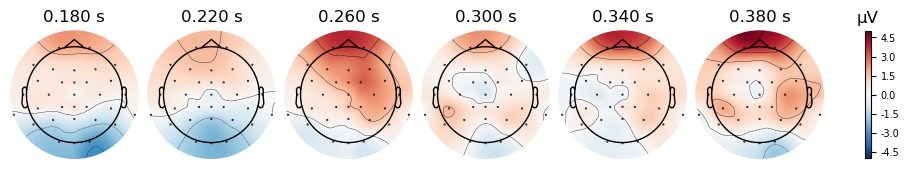

Plotting Topomap for: High-High


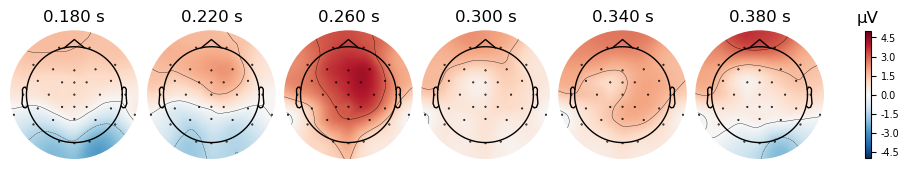

In [26]:
plot_topo_serires(diff_evokeds_prop_learner)

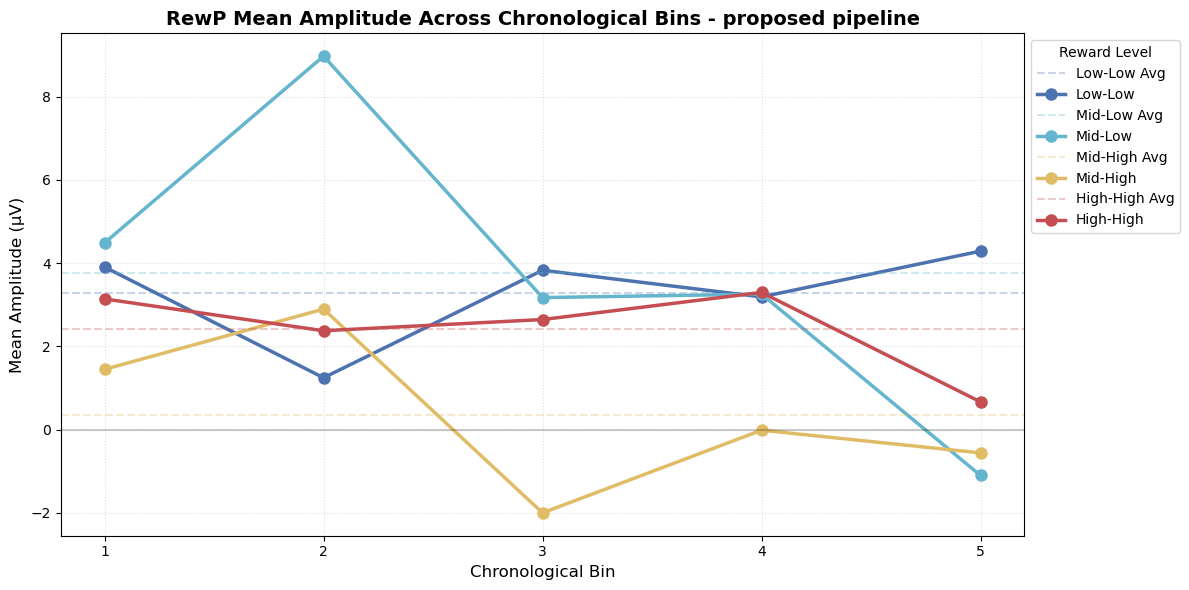

In [27]:
plot_binning_results(results_allbin_prop_learner, title=f'RewP Mean Amplitude Across Chronological Bins - {ACTIVE_PIPELINE} pipeline')

# Statistical tests 

In [27]:
GROUPS = {
    "ori_all": group_evokeds_ori,
    "ori_learner": group_evokeds_ori_learner,
    "prop_all": group_evokeds_prop,
    "prop_learner": group_evokeds_prop_learner,
}

group_label = 'prop_all'
group_evokeds = GROUPS[group_label]
print("Using group:", group_label, "| n_subjects =", len(group_evokeds))

Using group: prop_all | n_subjects = 12


In [28]:
# Logger + output dir
logger, out_dir, log_path = setup_rewp_logger(group_label)

# Build RewP scores (FCz, 240-340 ms)
ch_name = 'FCz'
tmin, tmax = 0.240, 0.340

scores, subjects, key_map = compute_rewp_scores(
                            group_evokeds, ch_name=ch_name, 
                            tmin=tmin, tmax=tmax, logger=logger)
logger.info(f"RewP scores computed for group: {group_label}")


# Save scores 
scores_path = out_dir / f"rewp_scores_{group_label}.csv"
_ = save_rewp_scores(scores, subjects, key_map, scores_path, 
                    ch_name=ch_name, tmin=tmin, tmax=tmax, logger=logger)

Logger initialized -> /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/output_mne/logs/rewp_stats_prop_all.log
Output dir: /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/output_mne
Check log file: /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/output_mne/logs/rewp_stats_prop_all.log
RewP scores shape: (12, 4)
Summary:
              LL         ML            MH         HH
count  12.000000  12.000000  1.200000e+01  12.000000
mean    0.000003   0.000002  8.909740e-07   0.000003
std     0.000005   0.000004  4.213050e-06   0.000004
Scores preview (head=8):
subject            LL            ML            MH            HH
     27  3.407326e-06  1.973151e-06 -1.610615e-07  1.465780e-07
     28 -6.704115e-06 -3.844731e-06 -6.138559e-06 -6.348807e-06
     29  1.249949e-06  2.037467e-06 -6.120102e-07  7.341485e-07
     30  3.909596e-06 -1.272723e-06  1.280878e-06  4.783235e-06
     

In [29]:
# Load and run stats from saved file
scores_loaded, subjects_loaded, key_map_loaded, meta = load_rewp_scores(scores_path, logger=logger)

# Parametric stats (rmANOVA + rmTTest)
param_res = run_rewp_parametric_from_scores(scores_loaded, subjects_loaded, key_map_loaded, logger=logger)

# Robustness checks: permutation + bootstrap
robust_res = run_rewp_robustness(scores_loaded, n_perm=10000, n_boot=10000, seed=0, logger=logger)

# Save clean tables
param_out = out_dir /  f"rewp_parametric_{group_label}.csv"
robust_out = out_dir / f"rewp_robustness_{group_label}.csv"
_ = save_parametric_results(param_res, param_out, logger=logger)
_ = save_robustness_results(robust_res, robust_out, logger=logger)

RewP diff score shape:
Condition mapping:

=== rmANOVA on RewP diffs (LL, ML, MH, HH) ===
Normality var 1: met (p=0.7111)
Normality var 2: met (p=0.9729)
Normality var 3: met (p=0.3556)
Normality var 4: met (p=0.8742)
RM ANOVA: F(3,33) = 1.242, p = 0.3102
partial eta^2 = 0.1015
generalized eta^2 = 0.03131
Friedman: chi2 = 3.9, p = 0.2725

=== rmTTest ===
Mid-Low vs Low-Low
Normality diff: met (p=0.09102)
t(11) = -0.2977, p = 0.7715
Cohen's d = -0.08593
Mid-High vs High-High
Normality diff: met (p=0.7186)
t(11) = -2.039, p = 0.0662
Cohen's d = -0.5887

=== Permutation tests ===
Mid-Low vs Low-Low
perm p = 0.8077, stat = -0.2977, n = 12
Mid-High vs High-High
perm p = 0.06549, stat = -2.039, n = 12

=== Bootstrap CIs ===
Mid-Low vs Low-Low
mean diff = -4.292e-07, CI = (-3.3451149180952434e-06, 1.957294442115226e-06)
Cohen's d = -0.08593, CI = (-0.5722917532756389, 0.7616040510197566)
Mid-High vs High-High
mean diff = -1.676e-06, CI = (-3.209706401817227e-06, -1.403703707782151e-07)
Cohen'